In [ ]:
# | default_exp analyses.repneighborcrp
%load_ext autoreload
%autoreload 2

## Extension: Repetition-Neighbor Lag-CRP
The lag-CRP measures the probability of recalling an item at a particular lag **given the current recall position**, conditional on items that remain available for recall. 
Here we follow up on our previous repetition-robust implementation of the Lag-CRP analysis, as well as our Repetition Lag-CRP analysis that separately tracks transitions from repeated items to their neighbors, with a new implementation that allows us to calculate the **Repetition-Neighbor Lag-CRP**.

In this analysis, we calculate transition probabilities from neighbors of the second presentation of repeated items to neighbors of the first presentation of the same repeated items, and/or vice versa.
This allows us to investigate how item repetition affects the contextual features associated with neighboring items in a study list as indicated in free recall.

For repeated items studied at positions $i$ and $j$ with spacing of at least 4 study positions, in this version of the analysis:

1. We only tabulate lag-transitions from recalls of items studied at position $j+1$ and/or $j+2$.
2. We tabulate lags according to the study position of the first presentation of the repeated item, so that we can calculate associations with neighbors of position $i$.

We optionally also or alternatively consider transitions from recalls of items studied at position $i+1$ and/or $i+2$ to neighbors of the repeated item at position $j$.

## Calculation

In [ ]:
# | exports
from typing import Literal, Optional, Sequence

from jax import jit, lax, vmap
from jax import numpy as jnp
from matplotlib import rcParams  # type: ignore
from matplotlib.axes import Axes
from simple_pytree import Pytree

from jaxcmr.plotting import init_plot, plot_data, set_plot_labels
from jaxcmr.repetition import all_study_positions
from jaxcmr.typing import Array, Bool, Float, Int_, Integer, RecallDataset


In [ ]:
# | exports


def set_false_at_index(vec: Bool[Array, " positions"], i: Int_):
    return lax.cond(i, lambda: (vec.at[i - 1].set(False), None), lambda: (vec, None))


class NeighborCRPTabulation(Pytree):
    """A tabulation of transitions between items during recall of a study list.

    This class generalizes several "repetition-neighbor" contiguity analysis variants by
    letting you choose whether to count transitions:
        - from j-neighbor → i  (“j2i”),
        - from i-neighbor → j  (“i2j”),
        - or both,
    and whether to include lag-2 offsets as well as lag-1.

    Args:
        presentation: Sequence of presented item indices (1-indexed; padding = 0).
        first_recall: Study position (1-indexed) of the first recalled item in this trial.
        direction: Track j-neighbor→i ("j2i"), i-neighbor→j ("i2j"), or "both".
        use_lag2: If True, include both +1 and +2 neighbor offsets; else only +1.
        min_lag: Minimum spacing between first and second presentations of the same item.
    """

    def __init__(
        self,
        presentation: Integer[Array, " study_events"],
        first_recall: Int_,
        min_lag: int = 4,
        direction: Literal["j2i", "i2j", "both"] = "both",
        use_lag2: bool = True,
    ):
        size = 2
        self.list_length = presentation.size
        self.lag_range = self.list_length - 1
        self.all_positions = jnp.arange(1, self.list_length + 1, dtype=int)
        self.base_lags = jnp.zeros(self.lag_range * 2 + 1, dtype=int)
        self.item_study_positions = lax.map(
            lambda i: all_study_positions(i, presentation, size),
            self.all_positions,
        )

        # Get first and second study positions
        first_positions = self.item_study_positions[:, 0]
        second_positions = self.item_study_positions[:, 1]

        # construct mask identify repeaters that are sufficiently spaced apart
        spaced_repeaters = (second_positions - first_positions) > min_lag

        # separately identify the first and second positions of just spaced repeaters
        first_mapped = jnp.where(spaced_repeaters, first_positions, 0)
        second_mapped = jnp.where(spaced_repeaters, second_positions, 0)

        # build two 0/1 masks from your args
        use_j2i = direction in ("j2i", "both")
        use_i2j = direction in ("i2j", "both")

        self.ijplus_12_to_ji = (
            jnp.zeros((self.list_length, 4), dtype=int)
            # mapping from second-presentation neighbors j+1, j+2 to i
            .at[second_positions + 1, 0]
            .set(first_mapped * use_j2i)
            .at[second_positions + 2, 1]
            .set(first_mapped * use_j2i * use_lag2)
            # mapping from first-presentation neighbors to j+1/j+2
            .at[first_positions + 1, 2]
            .set(second_mapped * use_i2j)
            .at[first_positions + 2, 3]
            .set(second_mapped * use_i2j * use_lag2)
        )

        self.actual_lags = jnp.zeros(self.lag_range * 2 + 1, dtype=int)
        self.avail_lags = jnp.zeros(self.lag_range * 2 + 1, dtype=int)

        self.previous_positions = self.item_study_positions[first_recall - 1]
        self.avail_recalls = jnp.ones(self.list_length, dtype=bool)
        self.avail_recalls = self.available_recalls_after(first_recall)

    # for updating avail_recalls: study positions still available for retrieval
    def available_recalls_after(self, recall: Int_) -> Bool[Array, " positions"]:
        "Update the study positions available to retrieve after a transition."
        study_positions = self.item_study_positions[recall - 1]
        return lax.scan(set_false_at_index, self.avail_recalls, study_positions)[0]

    # for updating actual_lags: lag-from-i-transitions actually made from the previous j+1/2 item
    # and/or lag-from-j-transitions actually made from the previous i+1/2 item
    def lags_from_ij(self, pos: Int_) -> Bool[Array, " positions"]:
        "Compute lags from all valid i/j (mapped from j+1/j+2 or i+1/i+2) to this recall_pos."

        def f(prev):
            def lag_from(ij):
                return self.base_lags.at[pos - ij + self.lag_range].add(1)

            def maybe_lag(ij):
                return lax.cond(
                    (pos * ij) == 0, lambda: self.base_lags, lambda: lag_from(ij)
                )

            return lax.map(maybe_lag, self.ijplus_12_to_ji[prev]).sum(0)

        return lax.map(f, self.previous_positions).sum(0).astype(bool)

    def tabulate_actual_lags(self, recall: Int_) -> Integer[Array, " lags"]:
        "Tabulate the actual transition after a transition."
        recall_study_positions = self.item_study_positions[recall - 1]
        new_lags = (
            lax.map(self.lags_from_ij, recall_study_positions).sum(0).astype(bool)
        )
        return self.actual_lags + new_lags

    # for updating avail_lags: lag-from-i-transitions available from the previous j+1/2 item
    def available_lags_from_ij(self, prev_pos: Int_) -> Bool[Array, " lags"]:
        "Compute recallable lag transitions from the mapped i to all positions in avail_recalls."
        i_values = self.ijplus_12_to_ji[prev_pos]

        def lag_from(ij):
            return self.base_lags.at[self.all_positions - ij + self.lag_range].add(
                self.avail_recalls
            )

        def maybe_lag(ij):
            return lax.cond(ij == 0, lambda: self.base_lags, lambda: lag_from(ij))

        return lax.map(maybe_lag, i_values).sum(0).astype(bool)

    def tabulate_available_lags(self) -> Integer[Array, " lags"]:
        "Tabulate available transitions after a transition."
        new_lags = (
            lax.map(self.available_lags_from_ij, self.previous_positions)
            .sum(0)
            .astype(bool)
        )
        return self.avail_lags + new_lags

    # unifying tabulation of actual/avail lags, previous positions, and avail recalls
    def should_tabulate(self) -> Bool:
        "Only consider transitions from item studied after second presentation of valid repeater."
        return jnp.any(self.ijplus_12_to_ji[self.previous_positions] > 0)

    def conditional_tabulate(self, recall: Int_) -> "NeighborCRPTabulation":
        "Only tabulate actual and possible lags if the additional condition is met."
        return lax.cond(
            self.should_tabulate(),
            lambda: self.replace(
                previous_positions=self.item_study_positions[recall - 1],
                avail_recalls=self.available_recalls_after(recall),
                actual_lags=self.tabulate_actual_lags(recall),
                avail_lags=self.tabulate_available_lags(),
            ),
            lambda: self.replace(
                previous_positions=self.item_study_positions[recall - 1],
                avail_recalls=self.available_recalls_after(recall),
            ),
        )

    def is_valid_recall(self, recall: Int_) -> Bool:
        "Only consider transitions to items with study positions that have not been recalled yet."
        recall_study_positions = self.item_study_positions[recall - 1]
        is_valid_study_position = recall_study_positions != 0
        is_available_study_position = self.avail_recalls[recall_study_positions - 1]
        return jnp.any(is_valid_study_position & is_available_study_position)

    def tabulate(self, recall: Int_) -> "NeighborCRPTabulation":
        "Tabulate actual and possible serial lags of current from previous item."
        return lax.cond(
            self.is_valid_recall(recall),
            lambda: self.conditional_tabulate(recall),
            lambda: self,
        )

We include a `tabulate_trial` method that takes a trial and updates the `NeighborCRPTabulation` object with the actual and available transitions for each lag at each recall attempt. Unlike the previous implementation, we directly return actual and available lag tabulations across the trial.

Then in our `repneighborcrp` function, we aggregate the counts of actual and available transitions across all trials, and divide the actual transitions by the available transitions to get the Repetition-Neighbor Lag-CRP for each lag.

In [ ]:
# | exports


def tabulate_trial(
    trial: Integer[Array, " recall_events"],
    presentation: Integer[Array, " study_events"],
    direction: Literal["j2i", "i2j", "both"] = "j2i",
    use_lag2: bool = False,
) -> tuple[Float[Array, " lags"], Float[Array, " lags"]]:
    """Returns actual and available neighbor-lag transition counts for a single recall trial.

    Args:
        trial: first study position of recalled items in order of recall; (1-indexed; padding = 0).
        presentations: sequence of presented item indices (1-indexed; padding = 0).
        direction: "j2i", "i2j", or "both"
        use_lag2: include both +1 and +2 neighbor offsets if True, else only +1
    """
    init = NeighborCRPTabulation(
        presentation, trial[0], direction=direction, use_lag2=use_lag2
    )
    tab = lax.fori_loop(1, trial.size, lambda i, t: t.tabulate(trial[i]), init)
    return tab.actual_lags, tab.avail_lags


def repneighborcrp(
    trials: Integer[Array, "trials recall_events"],
    presentations: Integer[Array, "trials study_events"],
    direction: Literal["j2i", "i2j", "both"] = "both",
    use_lag2: bool = True,
) -> Float[Array, " lags"]:
    """Returns repetition-neighbor lag-CRP probabilities per lag.

    Args:
        trials: recall event first-study positions for each trial (1-indexed; padding=0)
        presentations: presented item indices for each trial (1-indexed; padding=0)
        direction: "j2i", "i2j", or "both"
        use_lag2: include both +1 and +2 neighbor offsets if True, else only +1
    """

    tabulate_trials = vmap(tabulate_trial, in_axes=(0, 0, None, None))
    actual, possible = tabulate_trials(trials, presentations, direction, use_lag2)
    return actual.sum(0) / possible.sum(0)

## Plotting

In [ ]:
# | exports


def plot_rep_neighbor_crp(
    datasets: Sequence[RecallDataset] | RecallDataset,
    trial_masks: Sequence[Bool[Array, " trial_count"]] | Bool[Array, " trial_count"],
    max_lag: int = 3,
    direction: Literal["j2i", "i2j", "both"] = "both",
    use_lag2: bool = True,
    distances: Optional[Float[Array, "word_count word_count"]] = None,
    color_cycle: Optional[list[str]] = None,
    labels: Optional[Sequence[str]] = None,
    contrast_name: Optional[str] = None,
    axis: Optional[Axes] = None,
) -> Axes:
    """Returns Axes object with plotted prob of lag-CRP for datasets and trial masks.

    Args:
        datasets: Datasets containing trial data to be plotted.
        trial_masks: Masks to filter trials in datasets.
        max_lag: Maximum lag to plot.
        direction: Direction of neighbor transitions ("j2i", "i2j", or "both").
        use_lag2: If True, include both +1 and +2 neighbor offsets; else only +1.
        color_cycle: List of colors for plotting each dataset.
        distances: Unused, included for compatibility with other plotting functions.
        labels: Names for each dataset for legend, optional.
        contrast_name: Name of contrast for legend labeling, optional.
        axis: Existing matplotlib Axes to plot on, optional.
    """
    axis = init_plot(axis)

    if color_cycle is None:
        color_cycle = [each["color"] for each in rcParams["axes.prop_cycle"]]

    if labels is None:
        labels = [""] * len(datasets)

    if isinstance(datasets, dict):
        datasets = [datasets]

    if isinstance(trial_masks, jnp.ndarray):
        trial_masks = [trial_masks]

    lag_interval = jnp.arange(-max_lag, max_lag + 1, dtype=int)

    for data_index, data in enumerate(datasets):
        lag_range = (jnp.max(data["listLength"]) - 1).item()

        func = jit(repneighborcrp, static_argnums=(2, 3))
        trial_mask = trial_masks[data_index]
        trials = data["recalls"]
        presentations = data["pres_itemnos"]
        subject_indices = data["subject"].flatten()
        subject_values = []

        for subject in jnp.unique(data["subject"]):
            subject_mask = jnp.logical_and(subject_indices == subject, trial_mask)
            if jnp.sum(subject_mask) == 0:
                continue
            subject_values.append(
                func(
                    trials[subject_mask],
                    presentations[subject_mask],
                    direction=direction,
                    use_lag2=use_lag2,
                )
            )

        subject_values = jnp.vstack(subject_values)
        subject_values = subject_values[
            :, lag_range - max_lag : lag_range + max_lag + 1
        ]

        color = color_cycle.pop(0)
        plot_data(
            axis,
            lag_interval,
            subject_values,
            labels[data_index],
            color,
        )

    # build a dynamic x-axis label
    if direction == "j2i":
        xlabel = "Lag from 1st Presentation"
    elif direction == "i2j":
        xlabel = "Lag from 2nd Presentation"
    else:
        xlabel = "Lag from 1st/2nd Presentation"
    set_plot_labels(axis, xlabel, "Conditional Resp. Prob.", contrast_name)
    return axis


# wrapper functions configuring each direction, always using lag2:

def plot_repneighborcrp_j2i(
    datasets: Sequence[RecallDataset] | RecallDataset,
    trial_masks: Sequence[Bool[Array, " trial_count"]] | Bool[Array, " trial_count"],
    max_lag: int = 3,
    distances: Optional[Float[Array, "word_count word_count"]] = None,
    color_cycle: Optional[list[str]] = None,
    labels: Optional[Sequence[str]] = None,
    contrast_name: Optional[str] = None,
    axis: Optional[Axes] = None,
) -> Axes:
    return plot_rep_neighbor_crp(
        datasets,
        trial_masks,
        max_lag=max_lag,
        direction="j2i",
        use_lag2=True,
        distances=distances,
        color_cycle=color_cycle,
        labels=labels,
        contrast_name=contrast_name,
        axis=axis,
    )
def plot_repneighborcrp_i2j(
    datasets: Sequence[RecallDataset] | RecallDataset,
    trial_masks: Sequence[Bool[Array, " trial_count"]] | Bool[Array, " trial_count"],
    max_lag: int = 3,
    distances: Optional[Float[Array, "word_count word_count"]] = None,
    color_cycle: Optional[list[str]] = None,
    labels: Optional[Sequence[str]] = None,
    contrast_name: Optional[str] = None,
    axis: Optional[Axes] = None,
) -> Axes:
    return plot_rep_neighbor_crp(
        datasets,
        trial_masks,
        max_lag=max_lag,
        direction="i2j",
        use_lag2=True,
        distances=distances,
        color_cycle=color_cycle,
        labels=labels,
        contrast_name=contrast_name,
        axis=axis,
    )
def plot_repneighborcrp_both(
    datasets: Sequence[RecallDataset] | RecallDataset,
    trial_masks: Sequence[Bool[Array, " trial_count"]] | Bool[Array, " trial_count"],
    max_lag: int = 3,
    distances: Optional[Float[Array, "word_count word_count"]] = None,
    color_cycle: Optional[list[str]] = None,
    labels: Optional[Sequence[str]] = None,
    contrast_name: Optional[str] = None,
    axis: Optional[Axes] = None,
) -> Axes:
    return plot_rep_neighbor_crp(
        datasets,
        trial_masks,
        max_lag=max_lag,
        direction="both",
        use_lag2=True,
        distances=distances,
        color_cycle=color_cycle,
        labels=labels,
        contrast_name=contrast_name,
        axis=axis,
    )

## Examples

j2i


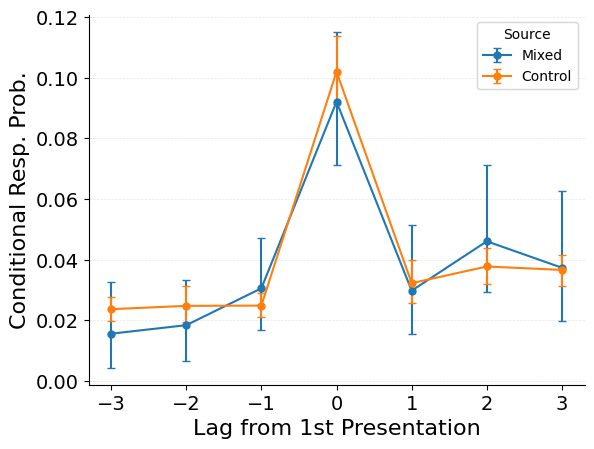

i2j


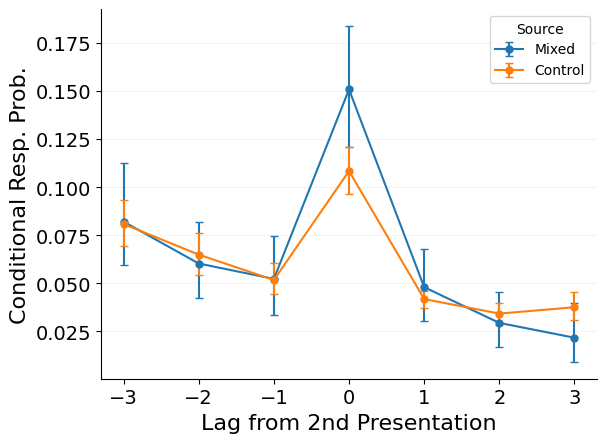

both


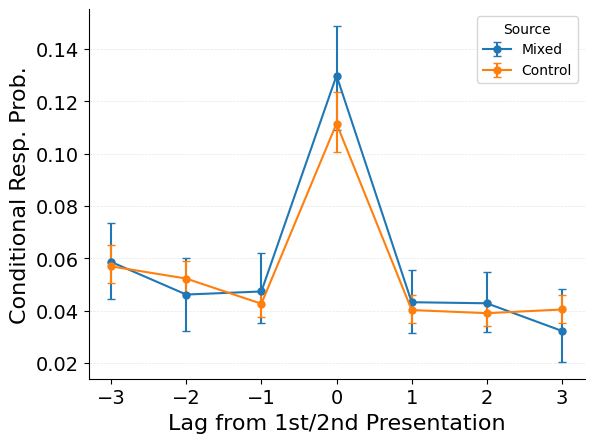

In [ ]:
import os
from jaxcmr.helpers import find_project_root, generate_trial_mask, load_data
from jaxcmr.repetition import make_control_dataset
from jaxcmr.typing import RecallDataset
import matplotlib.pyplot as plt

# parameters
data_query = "data['list_type'] == 4"
control_trial_query = "data['list_type'] == 1"
data_path = os.path.join(find_project_root(), "data/LohnasKahana2014.h5")

# set up data structures
data: RecallDataset = load_data(data_path) # type: ignore
trial_mask = generate_trial_mask(data, data_query)

# create control dataset
ctrl_data = make_control_dataset(
    data,
    mixed_query=data_query,
    control_query=control_trial_query,
    n_shuffles=10,
    seed=0,
)
# control_trial_mask = generate_trial_mask(ctrl_data, data_query)
control_trial_mask = jnp.ones((ctrl_data["recalls"].shape[0],), dtype=bool)

# plot
direction = "j2i"
print(direction)
plot_rep_neighbor_crp(
    [data, ctrl_data], [trial_mask, control_trial_mask], direction=direction, use_lag2=True, contrast_name="Source", labels=["Mixed", "Control"]
)
plt.show()

direction = "i2j"
print(direction)
plot_rep_neighbor_crp(
    [data, ctrl_data], [trial_mask, control_trial_mask], direction=direction, use_lag2=True, contrast_name="Source", labels=["Mixed", "Control"]
)
plt.show()

direction = "both"
print(direction)
plot_rep_neighbor_crp(
    [data, ctrl_data], [trial_mask, control_trial_mask], direction=direction, use_lag2=True, contrast_name="Source", labels=["Mixed", "Control"]
)
plt.show()